# Choosing the Generated AI Image

# 1. Imports and loading observed data

In [1]:
import numpy as np
import pickle
from pathlib import Path
import time
import torch
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim
import skimage.metrics

#VAE archecture package to be imported
from WildfirePredict.Task2.models.VAEmodel import VAE


In [2]:
obs_dataset = np.load('data/Ferguson_fire_obs.npy')
model_background_dataset = np.load("data/Ferguson_fire_background.npy")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
split_size = 5
channel_size = 100//split_size -1
latent_dim = 64
image_size = 256

model_path = 'data/Final_Linear.pth'
model = VAE(latent_dim = latent_dim, 
                channel_size = channel_size
                ).to(device)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

Here model architecture is loaded with the weights that were produced by the origional training of the model. The spilt size value indercates which images will be sampled out of groups of 100 squential images, e.g. if split_size =5 then every 5th image out of the goup of 100 will be sampled, meaning there will be 19 images per group, which is depicted by the channel size. 

We generate 10 images:

In [6]:
nums = (torch.randn((2,64))).to(device)
samples = model.decoder(nums).cpu().detach().numpy()

In [8]:
generated_images = []
for i in range(18):
    generated_images.append(samples[0].reshape(1, channel_size, 256, 256)[0][i])

In [9]:
generated_images = np.array(generated_images)

In [10]:
print(f"The shape of the generated images {generated_images.shape}")
print(f"The shape of the obs_dataset {obs_dataset.shape}")
print(f"The shape of the model background dataset {model_background_dataset.shape}")

(18, 256, 256)

The obs_dataset and model_background are made up of 5 images as there are 5 images out of the two datasets that align timewise and are therefore used.

In [13]:
generated_images = [img.astype(np.float32) for img in generated_images]
obs_dataset = obs_dataset.astype(np.float32)
model_background_dataset = model_background_dataset.astype(np.float32)

## Metric used to compare the data

In our study, we developed a comprehensive similarity metric to evaluate the resemblance between generated wildfire images and observed satellite images. The combined similarity score integrates three distinct metrics: Mean Squared Error (MSE), Cosine Similarity, and Peak Signal-to-Noise Ratio (PSNR). This formula is expressed as:

\begin{equation}
S(I_g, I_o) = w_1 \cdot \text{MSE}(I_g, I_o) + w_2 \cdot (1 - \text{Cosine Similarity}(I_g, I_o)) + w_3 \cdot \frac{1}{\text{PSNR}(I_g, I_o)}
\end{equation}


where $I_g$ represents the generated image, $I_o$ the observed image, and $w_1$, $w_2$, and $w_3$ are the weights assigned to each metric, reflecting their relative importance.

**Mean Squared Error (MSE)** measures the average squared differences between the pixel intensities of the generated and observed images. It is a fundamental metric for assessing pixel-wise accuracy and ensures that generated images closely follow the observed data on a pixel level. This is particularly important for wildfires, where precise detection of fire boundaries and intensity is crucial for accurate modeling and prediction. Lower MSE values indicate higher similarity.

**Cosine Similarity** evaluates the cosine of the angle between the flattened image vectors, providing a measure of orientation similarity. This metric captures the overall structure and orientation of the images, which is vital for wildfires that exhibit specific shapes and spread patterns. Accurate representation of these structural features is essential for understanding fire dynamics. By inverting the cosine similarity (using $1 - Cosine Similarity$) we align it with the principle that lower values indicate higher similarity.

**Peak Signal-to-Noise Ratio (PSNR)** assesses the ratio between the maximum possible pixel value and the power of the noise (difference) between the images. Higher PSNR values typically indicate that the generated image is of higher quality and more similar to the observed image. For wildfires, maintaining high image quality is important to ensure that critical details, such as hotspots and smoke plumes, are preserved. By using the reciprocal of PSNR, we integrate it into our formula such that lower values correspond to higher similarity.

By combining these three metrics, our formula captures a comprehensive assessment of image similarity. MSE ensures pixel-level accuracy, cosine similarity captures structural orientation, and PSNR evaluates image quality relative to noise. This multifaceted approach provides a robust and nuanced evaluation of the similarity between generated and observed wildfire images, facilitating more accurate assessments of model performance and better understanding of wildfire behavior.



In order to retrieve the weight of each of the metrics we are going to apply PCA. Applying PCA to the features (MSE, Cosine Similarity, and PSNR) of the generated and observed images helps to understand their relative importance. By calculating the explained variance ratio of each principal component, we can derive weights that reflect the significance of each metric in capturing the similarity between images.

In [14]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import skimage.metrics

In [15]:
from WildfirePredict.Task2.chosing_images.metrics import mse, psnr, cosine_sim
from WildfirePredict.Task2.chosing_images.feature_extraction import extract_features, compute_pca
from WildfirePredict.Task2.chosing_images.similarity_scoring import compare_images

First of all we will calculate the weights of the formula when comparing the AI generated images with the satellite data:

In [16]:
satellite_features = extract_features(generated_images, obs_dataset, mse, cosine_sim, psnr)
sw1, sw2, sw3 = compute_pca(satellite_features)
print("Derived weights for observed dataset:", sw1, sw2, sw3)

Derived weights for observed dataset: 0.36082465854449547 0.2760678877044181 0.3631074537510865


We do the same when comparing the AI generated images with the satellite data:

In [17]:
background_features = extract_features(generated_images, model_background_dataset, mse, cosine_sim, psnr)
bw1, bw2, bw3 = compute_pca(background_features)
print("Derived weights for background model dataset:", bw1, bw2, bw3)


Derived weights for background model dataset: 0.4609507885116537 0.07963446788199977 0.4594147436063465


PCA transforms the original metrics into principal components, each representing a combination of the original metrics that explain the variance in the dataset. By examining the contribution of each metric to the principal components, particularly the first principal component which accounts for the most variance, we can understand the relative importance of each metric. The explained variance ratio and the components' weights indicate how much each metric contributes to the overall variability in the data. Normalizing these contributions to sum to one allows us to derive meaningful weights that reflect the significance of each metric.

Now, we will check if we have same AI images when comparing with background and satellite.

When comparing with satellites:

Combined - Best match for observed image 0 at index: 10 with combined score: 0.0786225289142837


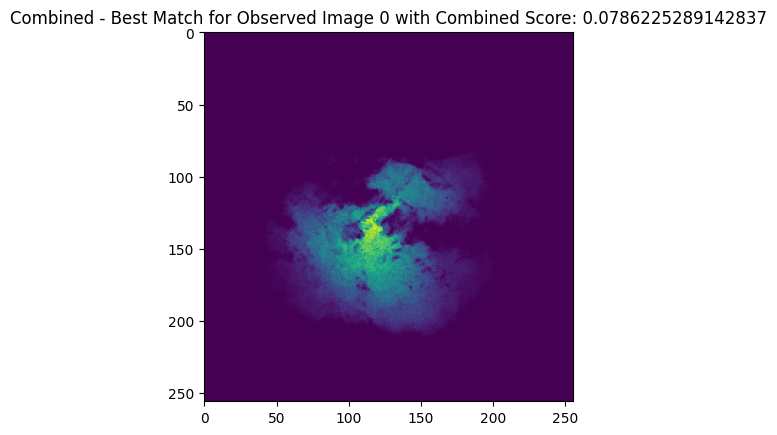

Combined - Best match for observed image 1 at index: 12 with combined score: 0.08921635762373037


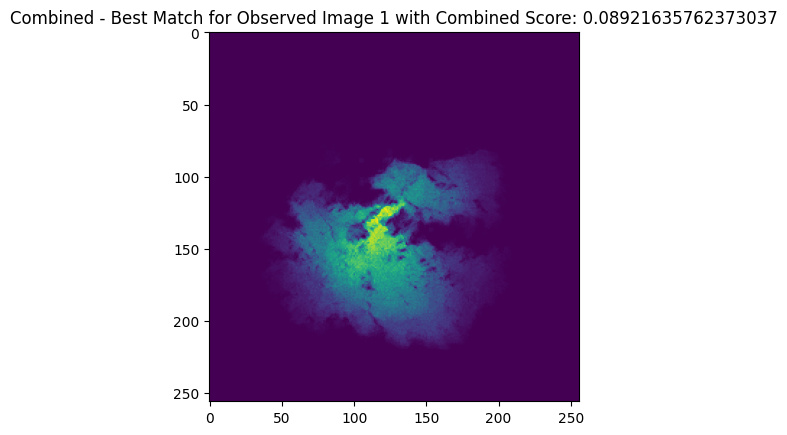

Combined - Best match for observed image 2 at index: 15 with combined score: 0.0978169601205407


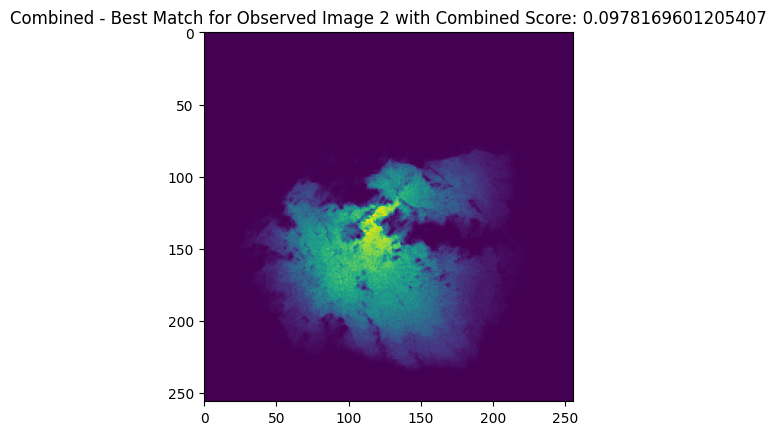

Combined - Best match for observed image 3 at index: 16 with combined score: 0.10508489192223475


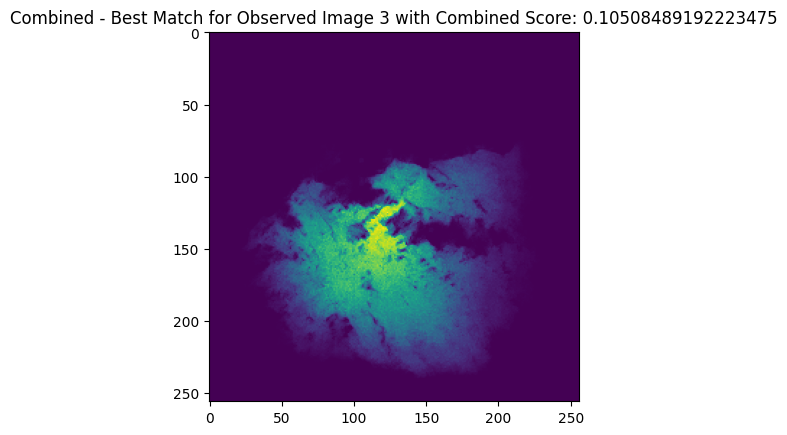

Combined - Best match for observed image 4 at index: 16 with combined score: 0.11221826119165809


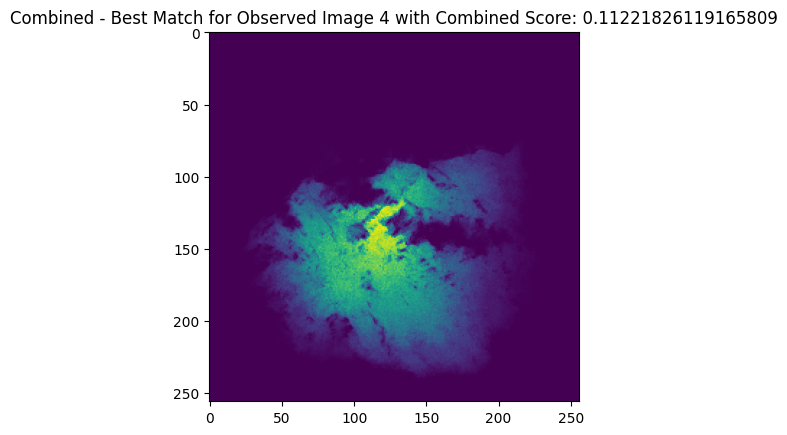

In [18]:
best_matches = compare_images(generated_images, obs_dataset)
for i, (best_match_idx, best_score) in enumerate(best_matches):
    print(f"Combined - Best match for observed image {i} at index: {best_match_idx} with combined score: {best_score}")
    plt.figure()
    plt.imshow(generated_images[best_match_idx], cmap='viridis')
    plt.title(f"Combined - Best Match for Observed Image {i} with Combined Score: {best_score}")
    plt.show()

When comparing with the background data:

Combined - Best match for observed image 0 at index: 7 with combined score: 0.064132969097815


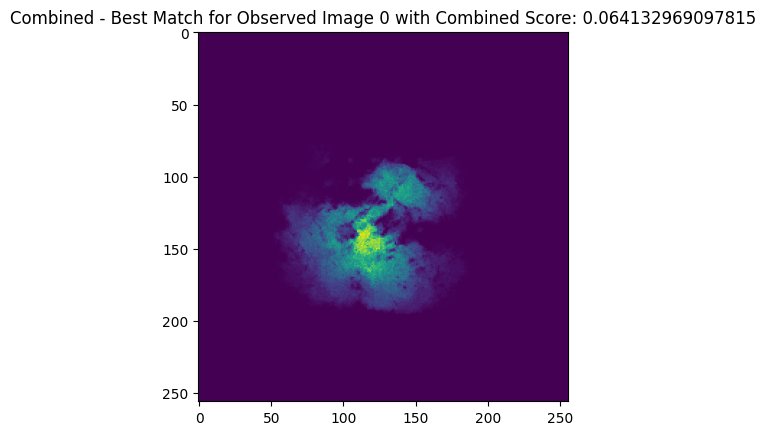

Combined - Best match for observed image 1 at index: 9 with combined score: 0.06760413856550734


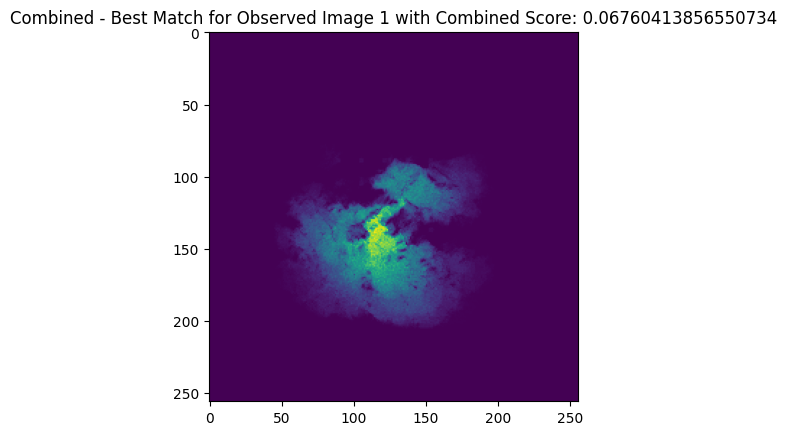

Combined - Best match for observed image 2 at index: 13 with combined score: 0.07063818278852749


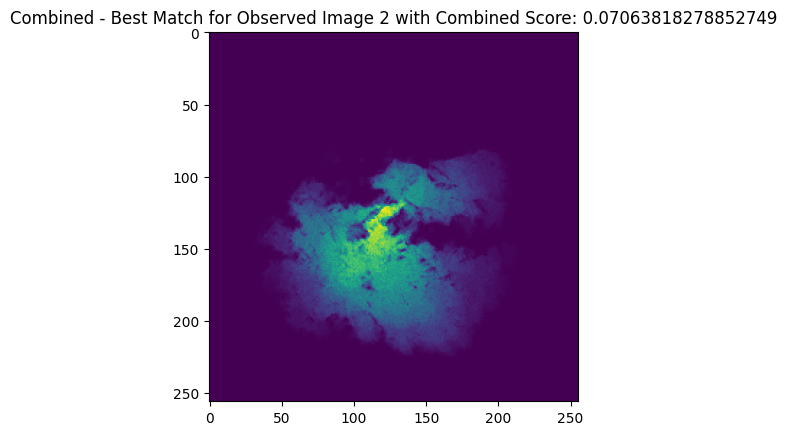

Combined - Best match for observed image 3 at index: 15 with combined score: 0.0744567709333009


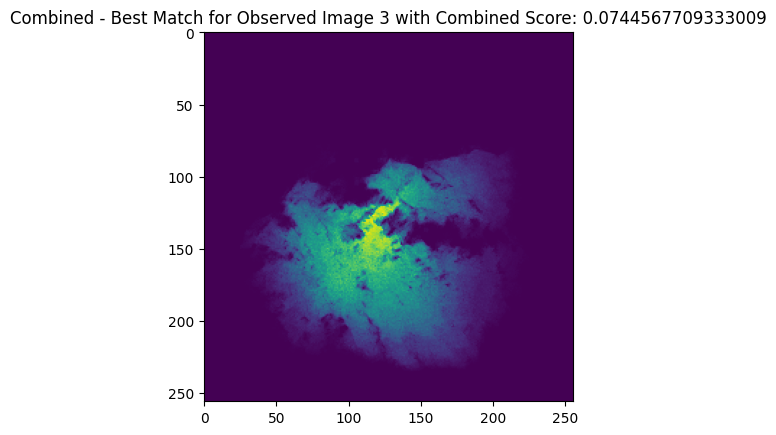

Combined - Best match for observed image 4 at index: 17 with combined score: 0.0790693638839557


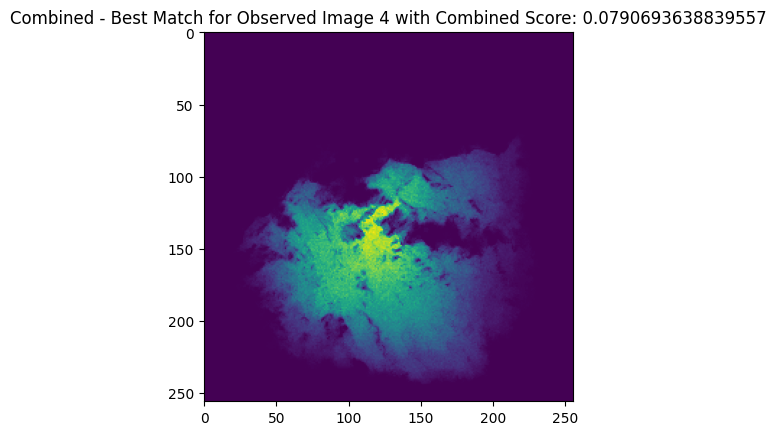

In [21]:
best_matches = compare_images(generated_images, model_background_dataset, w1=0.46, w2=0.08, w3=0.46)
for i, (best_match_idx, best_score) in enumerate(best_matches):
    print(f"Combined - Best match for observed image {i} at index: {best_match_idx} with combined score: {best_score}")
    plt.figure()
    plt.imshow(generated_images[best_match_idx], cmap='viridis')
    plt.title(f"Combined - Best Match for Observed Image {i} with Combined Score: {best_score}")
    plt.show()

When we compare our AI-generated images with satellite data, we find that only 2 of the AI images match the 5 satellite images. However, when we compare the AI-generated images with the background model data, we get 5 distinct AI images corresponding to the 5 different sets of background data. 

For Task 2, we opted to use a Variational Autoencoder (VAE) model trained on 3D data incorporating time steps. From each original series of 100 time steps, we selected 20 time steps, each spaced 5 steps apart. The datasets were then created with the first 19 steps for training and the last 19 steps for validation, corresponding to $t$ and $t+1$ for training and validation, respectively. Consequently, the input and output shapes for the model are both (19, 256, 256), representing 19 images of the respective time steps. **The model is trained to predict the state 5 time steps ahead.**

To identify the best corresponding time steps to the satellite images, we calculated the metric shown above between each generated image and the background images. The lowest metric value for the first background image was found at the 7th generated image (40th time step), and for the second background image at the 9th generated image (50th time step). This alignment indicated that our model accurately reflected the background/satellite data, which was observed every 10 time steps. Therefore, we will select the 7th, 9th, 11th, 13th, and 15th images for data assimilation.

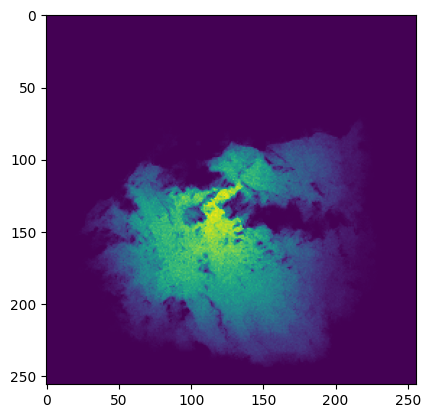

In [23]:
imageArrays =[]
for t in best_matches:
    imageArrays.append(generated_images[t[0]])
expanded_arrays = [np.expand_dims(arr, axis=0) for arr in imageArrays]
img_ar =np.array(expanded_arrays)
np.save(f'WildfirePredict/chosing_images/final_image.npy', img_ar)
image_array = np.load('WildfirePredict/chosing_images/final_image.npy')
plt.imshow(image_array[4][0])

Then our final formula with weights becomes:



\begin{equation}
S(I_g, I_o) = 0.46 \cdot \text{MSE}(I_g, I_o) + 0.08 \cdot (1 - \text{Cosine Similarity}(I_g, I_o)) + 0.46 \cdot \frac{1}{\text{PSNR}(I_g, I_o)}
\end{equation}
